In [10]:
import cv2
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
image_path='/Users/crispus/Desktop/capstone/data/VOC2007/JPEGImages'
xml_path='/Users/crispus/Desktop/capstone/data/VOC2007/Annotations'



In [15]:
def draw():
    image_index='PN121'
    global image_path,xml_path
    im_path=os.path.join(image_path,image_index+'.jpg')
    im=cv2.imread(im_path,1)
    xml_file_path=os.path.join(xml_path,image_index+'.xml')
    tree=ET.parse(xml_file_path)
    flaw = tree.find("object")
    bbox = flaw.find('bndbox')
    x1 = float(bbox.find('xmin').text)
    y1 = float(bbox.find('ymin').text)
    x2 = float(bbox.find('xmax').text)
    y2 = float(bbox.find('ymax').text)
    print("i am here")
    im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    image=cv2.rectangle(im,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0), 10)
#     cv2.imshow("te",image)
#     cv2.waitKey(0)
    print(x2-x1)
    plt.figure("Image") # 图像窗口名称
    plt.imshow(image)


i am here
79.36063999999999


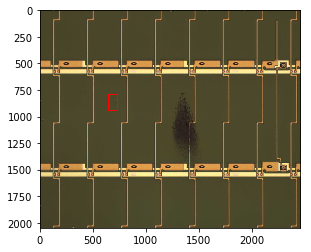

In [16]:
draw()

In [ ]:
def match_gt_box(rois,img_info):
    """
    The method to set label for rois to feed in Fast RCNN.
    :param rois: the rois box(xmin,ymin,xmax,ymax).
    :param img_info: the image_info which change_box(xmin,ymin,xmax,ymax)
    :return:the data to feed in Fast RCNN
    """
    # in this method i can implement to get the rois that i can not classfiy
    img_class=img_info.get('class')
    # gt_box is (xmin,xmax,xmax,ymax)
    gt_box=img_info.get('change_box')
    gt_box_square=(gt_box[2]-gt_box[0])*(gt_box[3]-gt_box[1])
    pos_roi_loc=[]
    neg_roi_loc=[]
    pos_lrecord=[]
    neg_lrecord=[]
    pos_record=[]
    neg_record=[]
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_box
    iou_pos=[]
    iou_neg=[]
    for roi in rois:
        xmin,ymin,xmax,ymax=roi
        xxmin=np.maximum(xmin,gt_xmin)
        yymin=np.maximum(ymin,gt_ymin)
        xxmax=np.minimum(xmax,gt_xmax)
        yymax=np.minimum(ymax,gt_ymax)
        if yymax-yymin<0 or xxmax-xxmin<0:
            continue
        roi_square = (roi[2] - roi[0]) * (roi[3] - roi[1])
        w=xxmax-xxmin
        h=yymax-yymin
        iou=w*h/(roi_square+gt_box_square-w*h)
        class_num=cfg.NUM_CLASSES-1
        record_loc = [0] * 8 * class_num
        if iou<0.1:
           gt_class = np.zeros([cfg.NUM_CLASSES], dtype=np.int32)
           gt_class[-1]=1
           neg_roi_loc.append(record_loc)
           neg_lrecord.append(gt_class)
           neg_record.append(roi)
           iou_neg.append(iou)
        else:
            pos_lrecord.append(img_info.get('class'))
            index=np.where(img_info.get('class')==1)[0][0]
            record_loc[4*index:4*index+4]=[1,1,1,1]
            pos_record.append(roi)
            roi_width=roi[2]-roi[0]
            roi_height=roi[3]-roi[1]
            roi=[roi[0]+roi_width/2,roi[1]+roi_height/2,roi_width,roi_height]
            record_loc[4*(class_num+index):4*(class_num+index+1)]=cal_offset(roi,gt_box)
            pos_roi_loc.append(record_loc)
            iou_pos.append(iou)
    neg_record = np.array(neg_record)
    neg_lrecord = np.array(neg_lrecord)
    neg_roi_loc = np.array(neg_roi_loc)
    if len(pos_lrecord) != 0:
        pos_roi_loc=np.array(pos_roi_loc)
        pos_lrecord=np.array(pos_lrecord)
        pos_record=np.array(pos_record)
        iou_pos=np.array(iou_pos)
        if len(pos_lrecord)>6:
            index=iou_pos.argsort()[::-1][:6]
            pos_record=pos_record[index,:]
            pos_lrecord=pos_lrecord[index,:]
            pos_roi_loc=pos_roi_loc[index,:]
        total_roi=np.concatenate((pos_record,neg_record),axis=0)
        label_record=np.concatenate((pos_lrecord,neg_lrecord),axis=0)
        roi_loc=np.concatenate((pos_roi_loc,neg_roi_loc),axis=0)
    else:
        total_roi=neg_record
        label_record=neg_lrecord
        roi_loc=neg_roi_loc
    return total_roi ,label_record,roi_loc